In [18]:
import numpy as np
import pandas as pd

from PIL import Image, ImageChops
from torchvision import transforms
from skimage.measure import compare_ssim
import matplotlib.pyplot as plt

import MCS2018_CPU as MCS2018
from student_net_learning.models import *

import os

import torch

In [11]:
def get_model(model_name, checkpoint_path):
    '''
    Model architecture choosing
    '''
    if model_name == 'ResNet18':
        net = ResNet18()
    elif model_name == 'ResNet34':
        net = ResNet34()
    elif model_name == 'ResNet50':
        net = ResNet50()
    elif model_name == 'ResNet152':
        net = ResNet152()
    elif model_name == 'DenseNet121':
        net = DenseNet121()
    elif model_name == 'DenseNet201':
        net = DenseNet201()
    elif model_name == 'VGG11':
        net = VGG('VGG11')
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    net.load_state_dict(checkpoint['net'])
    return net

In [47]:
solution_dir = 'imgs'
original_folder = 'data/imgs'
pairs_list_path = 'data/pairs_list.csv'
model_name = 'ResNet152'
checkpoint_path = 'student_net_learning/checkpoint/Baseline1/best_model_chkpt.t7'

SSIM_THR = 0.95
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

gpu_id = -1

cropping = transforms.Compose([transforms.CenterCrop(224),
                                   transforms.Resize(112)])

cropped_img_preprocessing = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=MEAN, std=STD)
                                ])

transform = transforms.Compose([
                transforms.CenterCrop(224),
                transforms.Resize(112),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD),
                ])

pairs_list = pd.read_csv(pairs_list_path)

def euclid_dist(x,y, axis=0): 
    return np.sqrt(((x - y) ** 2).sum(axis=axis))

In [9]:
black_box = MCS2018.Predictor(gpu_id)

In [14]:
white_box = get_model(model_name, checkpoint_path)
if gpu_id > -1:
    white_box = white_box.cuda()
white_box.eval()
def white_box_test(img):
    tensor = cropped_img_preprocessing(img).unsqueeze(0)
    
    if gpu_id > -1:
        tensor = tensor.cuda(async=True)
    res = white_box(Variable(tensor))
    res = res.data.cpu()
    res = res.numpy()
    return res.squeeze()

In [20]:
image_dictionary = dict()

for index, row in pairs_list.iterrows():
    target_imgs = row['target_imgs'].split('|')
    source_imgs = row['source_imgs'].split('|')
    for si in source_imgs:
        image_dictionary[si] = target_imgs

In [48]:
filenames = os.listdir(solution_dir)

In [38]:
attacked = Image.open(os.path.join(solution_dir, filenames[1]))
print(np.max(np.array(attacked)))

255


0.9461034483909607


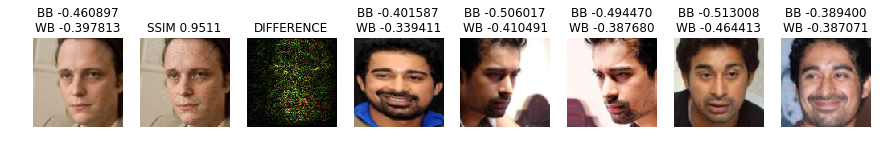

1.0648488647937775


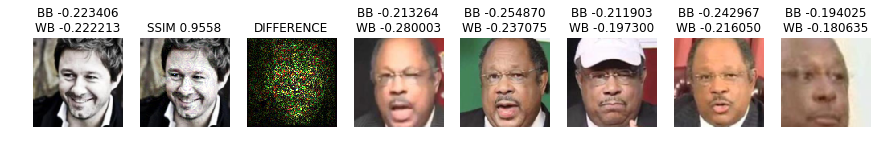

1.0888224688371022


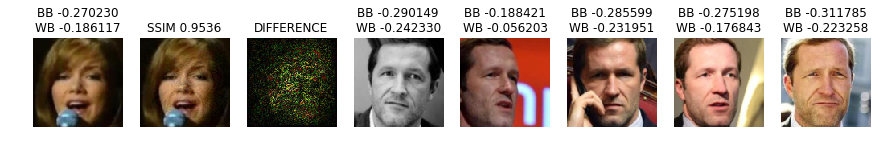

1.1065746083557606


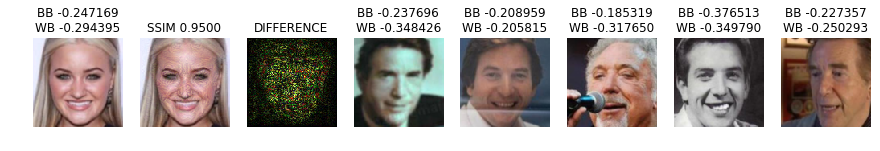

1.0963692284822464


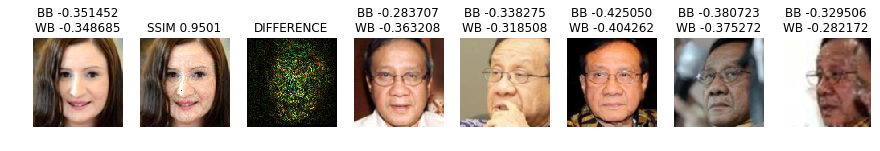

1.0933333508372307


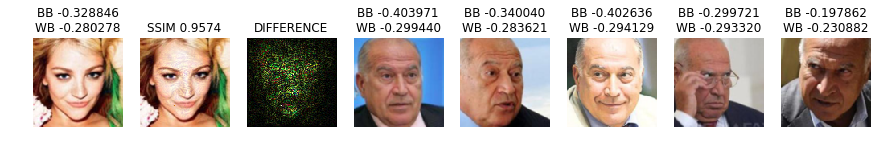

1.0560836590528488


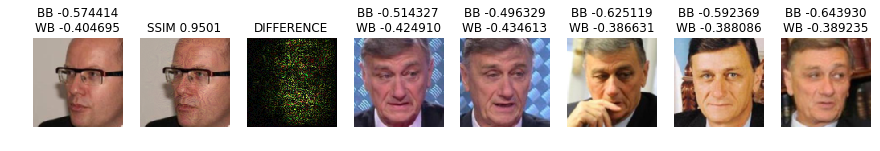

1.0659213516563177


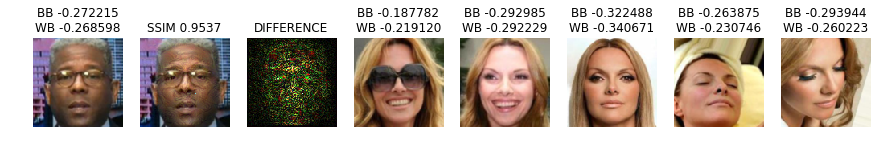

1.078411876877149


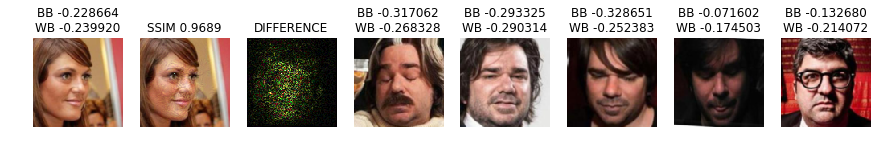

1.0865431345701217


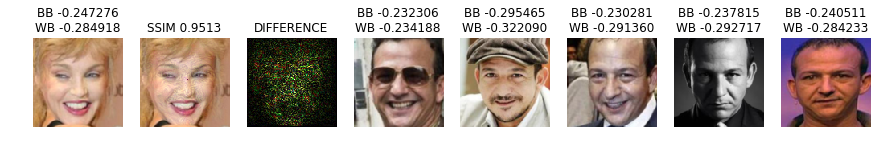

KeyboardInterrupt: 

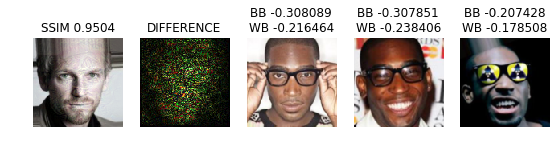

In [50]:
sum_bb_diff = 0
for fi, fn in enumerate(filenames[:100]):
    orig_name = fn.replace('.png', '.jpg')
    orig = Image.open(os.path.join(original_folder, orig_name))
    attacked = Image.open(os.path.join(solution_dir, fn))
    
    orig = cropping(orig)
    
    ssim = compare_ssim(np.array(attacked), np.array(orig), multichannel=True)
    if ssim < SSIM_THR:
        print("SSIM ERROR!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 8, 2)
    plt.title('SSIM %.4f' % ssim)
    plt.axis('off')
    plt.imshow(attacked)
    
    diff = ImageChops.difference(orig, attacked)
    diff = transforms.functional.adjust_brightness(diff, 10) # x10 brightness
    plt.subplot(1, 8, 3)
    plt.title('DIFFERENCE')
    plt.axis('off')
    plt.imshow(diff)
    
    batch_from_one_img = np.array(cropped_img_preprocessing(orig).unsqueeze(0), dtype=np.float32)
    D0 = black_box.submit(batch_from_one_img).squeeze()
    WD0 = white_box_test(orig)
    
    batch_from_one_img = np.array(cropped_img_preprocessing(attacked).unsqueeze(0), dtype=np.float32)
    D1 = black_box.submit(batch_from_one_img).squeeze()
    WD1 = white_box_test(attacked)
    
    diff_bb = []
    diff_wb = []
    for i in range(5):
        
        target = Image.open(os.path.join(original_folder, image_dictionary[orig_name][i]))
        target = cropping(target)
        batch_from_one_img = np.array(cropped_img_preprocessing(target).unsqueeze(0), dtype=np.float32)
        d = black_box.submit(batch_from_one_img).squeeze()
        d0 = euclid_dist(D0, d)
        d1 = euclid_dist(D1, d)
        diff_bb.append(d1 - d0)
        
        d = white_box_test(target)
        d0 = euclid_dist(WD0, d)
        d1 = euclid_dist(WD1, d)
        diff_wb.append(d1 - d0)
        
        plt.subplot(1, 8, 4 + i)
        plt.title('BB %.6f\nWB %.6f' % (diff_bb[i], diff_wb[i]))
        plt.axis('off')
        plt.imshow(target)

    plt.subplot(1, 8, 1)
    plt.title('BB %.6f\nWB %.6f' % (np.mean(diff_bb), np.mean(diff_wb)))
    sum_bb_diff += np.mean(diff_bb)
    plt.axis('off')
    plt.imshow(orig)
    print(1.407 + sum_bb_diff/(fi+1))
    plt.show()
    
    

In [51]:
from torch.autograd import variable

In [53]:
x = Variable(torch.from_numpy(np.array([[1, 2],[-3, 5]])))

In [59]:
x

Variable containing:
 1  2
-3  5
[torch.LongTensor of size 2x2]

In [74]:
t = x>0

In [73]:
y=x<0
z = -y.long() 

In [76]:
t.long()+z

Variable containing:
 1  1
-1  1
[torch.LongTensor of size 2x2]

In [64]:
x * y.long()

Variable containing:
 1  2
 0  5
[torch.LongTensor of size 2x2]